In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import env
from train_vaegan import train_vaegan

In [36]:
cfg = {
        "dataset": {
            "index": "../data/processed/thingi10k_index.csv",
            "tag": "animal",
            "pctile": 0.9
        },
        "model": {
            "voxels_dim": 32,
            "batch_size": 22,
            "example_stl_id": 126660,
            "voxel_prob_threshold": 0.065,
            "enc_lr": 0.0001,
            "dec_lr": 0.0001,
            "dis_lr": 0.0001,
            "keep_prob": 1.0,
            "kl_div_loss_weight": 1,
            "recon_loss_weight": 10000,            
            "latent_dim": 100,
            "verbose": True,
            "debug": True,
            "generator_verbose": False,
            "epochs": 10,
            "input_repeats": 1,
            "display_step": 10,
            "save_step": 10
        }
}

Logging to /home/jcworkma/jack/3d-form/src/logs/2019-03-06_16-13__root.log
Starting train_vaegan main
Using thingi10k with index ../data/processed/thingi10k_index.csv and pctile 0.9
Filtering thingi10k by tag: animal
Thingi10k n_input=154
Num input = 154
Num batches per epoch = 7.00
Initializing VoxelVaegan
encoder/enc_conv1/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 100)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 100)
epsilon: (?, 100)
z: (?, 100)
input_z: (?, 100)
decoder/dec_dense1/BiasAdd:0: (?, 343)
decoder/Elu:0: (?, 343)
decoder/reshape_z:0: (?, 7, 7, 7, 1)
decoder/batch_normalization_1/batchnorm/add_1:0: (?, 7, 7, 7, 64)
decoder/batch_normalization_2/batchn

DEBUG_OP "min clipped_output": 0.4636014699935913
DEBUG_OP "mean clipped_output": 0.4995764195919037
	KL Divergence = 1.526806116104126, Reconstruction Loss = 2140.40380859375, -dis_loss = -117.82308959960938, dec_loss = 97.28250885009766
Epoch: 2, Batch: 6, Elapsed time: 0.88 mins
DEBUG_OP "max clipped_output": 0.541694700717926
DEBUG_OP "min clipped_output": 0.462471604347229
DEBUG_OP "mean clipped_output": 0.4995615780353546
	KL Divergence = 1.3078124523162842, Reconstruction Loss = 1845.599365234375, -dis_loss = -114.77057647705078, dec_loss = 101.29273986816406
Epoch: 3, Batch: 0, Elapsed time: 0.92 mins
DEBUG_OP "max clipped_output": 0.5434792637825012
DEBUG_OP "min clipped_output": 0.4652262032032013
DEBUG_OP "mean clipped_output": 0.49942347407341003
	KL Divergence = 2.1296849250793457, Reconstruction Loss = 2023.216064453125, -dis_loss = -125.74080657958984, dec_loss = 104.0760726928711
Epoch: 3, Batch: 1, Elapsed time: 0.97 mins
DEBUG_OP "max clipped_output": 0.54280972480773

Epoch: 6, Batch: 2, Elapsed time: 1.94 mins
DEBUG_OP "max clipped_output": 0.5364891290664673
DEBUG_OP "min clipped_output": 0.46465426683425903
DEBUG_OP "mean clipped_output": 0.5003925561904907
	KL Divergence = 0.5125375390052795, Reconstruction Loss = 1926.218505859375, -dis_loss = -231.39926147460938, dec_loss = 169.32949829101562
Epoch: 6, Batch: 3, Elapsed time: 1.99 mins
DEBUG_OP "max clipped_output": 0.5366615653038025
DEBUG_OP "min clipped_output": 0.4627176821231842
DEBUG_OP "mean clipped_output": 0.5003470182418823
	KL Divergence = 0.47116386890411377, Reconstruction Loss = 1905.335693359375, -dis_loss = -249.77450561523438, dec_loss = 171.65611267089844
Epoch: 6, Batch: 4, Elapsed time: 2.03 mins
DEBUG_OP "max clipped_output": 0.5360347032546997
DEBUG_OP "min clipped_output": 0.4661481976509094
DEBUG_OP "mean clipped_output": 0.5003893971443176
	KL Divergence = 0.5284736156463623, Reconstruction Loss = 1784.653076171875, -dis_loss = -247.24986267089844, dec_loss = 175.63012

	KL Divergence = 0.8623321652412415, Reconstruction Loss = 2115.921142578125, -dis_loss = -382.23187255859375, dec_loss = 232.13601684570312
Epoch: 9, Batch: 6, Elapsed time: 3.05 mins
DEBUG_OP "max clipped_output": 0.5451215505599976
DEBUG_OP "min clipped_output": 0.46670001745224
DEBUG_OP "mean clipped_output": 0.503641664981842
	KL Divergence = 1.0287615060806274, Reconstruction Loss = 1824.34033203125, -dis_loss = -356.3319091796875, dec_loss = 225.1162872314453


Epoch: 10, Loss = 848.42749, KL Divergence = 1.02876, Reconstruction Loss = 1824.34033, -dis_Loss = -356.33191, dec_Loss = 225.11629, Elapsed time: 3.09 mins
Generation Example:


Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan/model_epoch-9.ckpt
DEBUG_OP "max clipped_output": 0.5309925079345703
DEBUG_OP "min clipped_output": 0.478598028421402
DEBUG_OP "mean clipped_output": 0.5038096904754639


Did not save experiment metrics


Done train_vaegan.py main
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


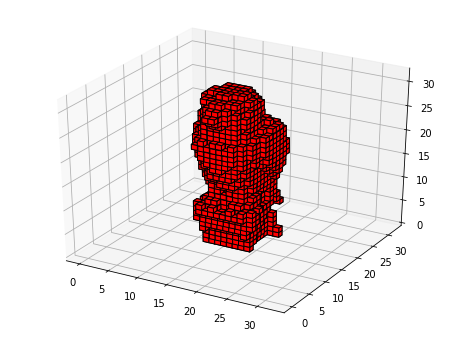

update_title_pos
update_title_pos
update_title_pos
update_title_pos


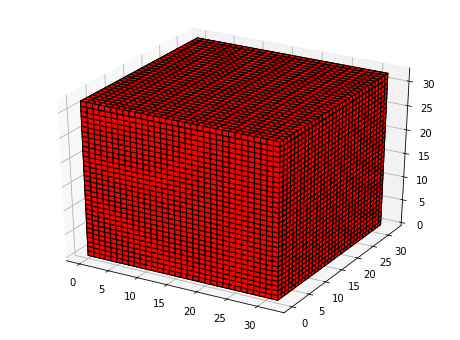

In [37]:
train_vaegan(cfg)